# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.13.1+cu117].
device:[cuda:0].


# Make test data

In [2]:
nlp = spacy.load("en_core_web_md")

test_data = [
    "This is a positive sentence with good vibes.",
    "I'm not sure about this, it could be either positive or negative.",
    "Negative sentiment is evident in this statement.",
    "The weather is great today!",
]

labels = [1, 0, -1, 1]

def get_sentence_embedding(sentence):
    doc = nlp(sentence)
    return np.mean([token.vector for token in doc if token.has_vector], axis=0)

In [3]:
X_train = np.array([get_sentence_embedding(sentence) for sentence in test_data])
X_train = torch.tensor(X_train)

## check data' shape

In [4]:
print(f"X_train's shape: {X_train.shape}")

X_train's shape: torch.Size([4, 300])


# Encoder

## MHA

In [5]:
class MultiHeadedAttention(nn.Module):
    def __init__(self,d_feat=512,n_head=8,actv=F.relu,device=None):
        super(MultiHeadedAttention, self).__init__()
        self.d_feat = d_feat
        self.n_head = n_head    #equal with d_k
        self.d_head = d_feat // n_head
        if self.d_head % self.n_head !=0:
            raise ValueError
        self.actv = actv

        self.lin_k = nn.Linear(self.d_feat, self.d_feat)
        self.lin_q = nn.Linear(self.d_feat, self.d_feat)
        self.lin_v = nn.Linear(self.d_feat, self.d_feat)

    def forward(self, Q, K, V):

        Query = self.lin_q(Q)
        Key = self.lin_k(K)
        Value = self.lin_v(V)

        #입력 쿼리는 n * s * d: batch * sequence_length * embedding length
        batch_size = Query.shape[0]
        Queries = Query.view(batch_size, self.n_head, -1, self.d_head)
        Keys = Key.view(batch_size, self.n_head, -1, self.d_head)
        Values = Value.view(batch_size, self.n_head, -1, self.d_head)

        attention_score = torch.matmul(Queries, Keys.permute(0,1,3,2))
        attention_score = attention_score / np.sqrt(Keys.shape[-1])
        attention_score = F.softmax(attention_score, dim = -1)
        # attention_score = batch * sequence_length * embedding length

        attention_score = torch.matmul(attention_score, Values)
        
        x = attention_score.permute(0, 2, 1, 3)
        x = attention_score.view(batch_size, -1, self.d_feat)

        return x

## FFN

In [6]:
class FeedForwardNetwork(nn.Module):
    def __init__(self,d_feat=512,n_head=8,actv=F.relu,device=None):
        super(FeedForwardNetwork, self).__init__()
        self.d_feat = d_feat
        self.actv = actv
        self.device = device
        self.n_head = n_head

        self.linear_1 = nn.Linear(self.d_feat, self.d_feat * 4)  
        self.linear_2 = nn.Linear(self.d_feat * 4, self.d_feat)       


    
    def forward(self, x):
        x = self.linear_1(x)
        x = self.actv(x)
        x = self.linear_2(x)
        x = self.actv(x)
        
        return x

## Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, d_feat=512, n_head=8, actv = F.relu, device=None):
        super(Encoder, self).__init__()
        self.d_feat = d_feat
        self.actv = actv
        self.device = device
        self.n_head = n_head

        self.MHA = MultiHeadedAttention(d_feat=self.d_feat, n_head = self.n_head, actv = self.actv, device = self.device)
        self.FFN = FeedForwardNetwork(d_feat=self.d_feat, n_head = self.n_head, actv = self.actv, device = self.device)

        self.layernorm_1 = nn.LayerNorm(d_feat)
        self.layernorm_2 = nn.LayerNorm(d_feat)

    def forward(self, x):
        output = self.MHA(x, x, x)

        x = x + output
        x = self.layernorm_1(x)
        output = self.FFN(x)
        x = x + output
        x = self.layernorm_2(x)

        return x

## Positional encoding

In [74]:
def positional_encoding(seq_len, dim):
    encoding = np.zeros((seq_len, dim))
    for s in range(seq_len):
        for d in range(dim):
            if d%2==0:
                encoding[s,d] = (np.sin(s/(10000**(2*d/dim))))
            else:
                encoding[s,d] = (np.cos(s/(10000**(2*d/dim))))
    return encoding

In [9]:
pos_enc = positional_encoding(100, 512)

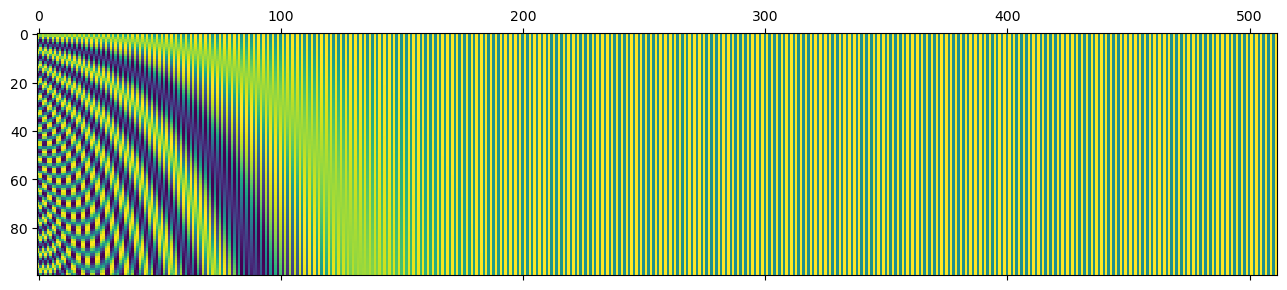

In [10]:
plt.matshow(pos_enc)

## Test encoder

In [11]:
x = torch.randn(16, 100, 512)
x + torch.from_numpy(positional_encoding(100, 512))
encoder = Encoder(d_feat=512, n_head=8, actv=F.relu)
y = encoder(x)
print(y.shape)

torch.Size([16, 100, 512])


# Decoder

In [17]:
class MaskedMultiHeadedAtttention(nn.Module):
    def __init__(self,d_feat=512,n_head=8,actv=F.relu,device=None):
        super(MaskedMultiHeadedAtttention, self).__init__()
        self.d_feat = d_feat
        self.n_head = n_head    #equal with d_k
        self.d_head = d_feat // n_head
        if self.d_head % self.n_head !=0:
            raise ValueError
        self.actv = actv

        self.lin_k = nn.Linear(self.d_feat, self.d_feat)
        self.lin_q = nn.Linear(self.d_feat, self.d_feat)
        self.lin_v = nn.Linear(self.d_feat, self.d_feat)

    def forward(self, Q, K, V):

        Query = self.lin_q(Q)
        Key = self.lin_k(K)
        Value = self.lin_v(V)

        #입력 쿼리는 n * s * d: batch * sequence_length * embedding length
        batch_size = Query.shape[0]
        Queries = Query.view(batch_size, self.n_head, -1, self.d_head)
        Keys = Key.view(batch_size, self.n_head, -1, self.d_head)
        Values = Value.view(batch_size, self.n_head, -1, self.d_head)

        attention_score = torch.matmul(Queries, Keys.permute(0,1,3,2))
        attention_score = attention_score / np.sqrt(Keys.shape[-1])

        ####이 부분에서 위치 이후의 attention값을 지워주어야함
        mask = torch.ones(1, 1, attention_score.size(-1), device=attention_score.device)
        mask = mask.tril(0).bool()      #주대각성분 아래는 유지 위는 0으로 만듦
        attention_score[:, :, ~mask] = float('-inf')

        attention_score = F.softmax(attention_score, dim = -1)
        # attention_score = batch * sequence_length * embedding length

        attention_score = torch.matmul(attention_score, Values)
        
        x = attention_score.permute(0, 2, 1, 3)
        x = attention_score.view(batch_size, -1, self.d_feat)

        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, d_feat=512, n_head=8, actv = F.relu, device=None):
        super(Encoder, self).__init__()
        self.d_feat = d_feat
        self.actv = actv
        self.device = device
        self.n_head = n_head

        self.MHA = MultiHeadedAttention(d_feat=self.d_feat, n_head = self.n_head, actv = self.actv, device = self.device)
        self.FFN = FeedForwardNetwork(d_feat=self.d_feat, n_head = self.n_head, actv = self.actv, device = self.device)

        self.layernorm_1 = nn.LayerNorm(d_feat)
        self.layernorm_2 = nn.LayerNorm(d_feat)

    def forward(self, x):
        output = self.MHA(x, x, x)

        x = x + output
        x = self.layernorm_1(x)
        output = self.FFN(x)
        x = x + output
        x = self.layernorm_2(x)

        return x

# Make encoder, decoder

In [84]:
class Encoder_Module(nn.Module):
    def __init__(self, seq_len=100, d_feat=512, n_head=8, actv = F.relu, device=None):
        super(Encoder_Module, self).__init__()
        self.emb = positional_encoding(seq_len, d_feat)
        
        self.encoders = [Encoder(d_feat=d_feat, n_head=n_head, actv=actv, device=device)
                         for _ in range(8)]
        
    def forward(self, x):
        emb = self.emb
        emb = torch.tensor(emb, dtype=x.dtype)
        x = emb + x
        for encoder in self.encoders:
            x = encoder(x)
        return x

In [ ]:
class Decoder_Module(nn.Module):
    def __init__(self, seq_len=100, d_feat=512, n_head=8, actv = F.relu, device=None):
        super(Encoder_Module, self).__init__()
        self.emb = positional_encoding(seq_len, d_feat)
        
        self.encoders = [Decoder(d_feat=d_feat, n_head=n_head, actv=actv, device=device)
                         for _ in range(8)]
        
    def forward(self, x):
        emb = self.emb
        emb = torch.tensor(emb, dtype=x.dtype)
        x = emb + x
        for encoder in self.encoders:
            x = encoder(x)
        return x

In [85]:
class Encoder(nn.Module):
    def __init__(self, d_feat=512, n_head=8, actv = F.relu, device=None):
        super(Encoder, self).__init__()
        self.d_feat = d_feat
        self.actv = actv
        self.device = device
        self.n_head = n_head

        self.MHA = MultiHeadedAttention(d_feat=self.d_feat, n_head = self.n_head, actv = self.actv, device = self.device)
        self.FFN = FeedForwardNetwork(d_feat=self.d_feat, n_head = self.n_head, actv = self.actv, device = self.device)

        self.layernorm_1 = nn.LayerNorm(d_feat)
        self.layernorm_2 = nn.LayerNorm(d_feat)

    def forward(self, x):
        output = self.MHA(x, x, x)

        x = x + output
        x = self.layernorm_1(x)
        output = self.FFN(x)
        x = x + output
        x = self.layernorm_2(x)

        return x

In [86]:
encoder = Encoder_Module(d_feat=512,n_head=8, device=device)

In [87]:
output = encoder(torch.randn(16, 100, 512))
print(output.shape)


torch.Size([16, 100, 512])


## Data test

In [65]:
encoder = Encoder(d_feat=512,n_head=8, device=device)
output = encoder(torch.randn(16, 100, 512))

In [15]:
output.shape

torch.Size([16, 512, 512])

In [16]:
torch.randn(2, 512).shape

torch.Size([2, 512])